# Summary 
Generates the geojson hexes+dissolved cities file.

Demonstrates calculation of 50/10 access levels from the NBD map data against arbitrary 
geometry other than the precomputed hexagons.

Calculating this requires joining the geometry from the Canada wide hexagons geometry 
with the tabular `PHH_Speeds_Current-PHH_Vitesses_Actuelles.csv` dataset. 

Loading the data and executing the spatial joins takes a total of 7 minutes.

In [1]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 1
%aimport src.datasets.joins
%aimport src.datasets.loading.statcan

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from src.datasets.loading import statcan
from src.datasets.loading import ookla
from src.datasets import overlays

from src.datasets import joins
import src

In [3]:
popctrs = statcan.boundary('population_centres')

In [4]:
popctrs.loc[lambda s:s.PCNAME == "Lloydminster"]

PCUID        PCNAME PCTYPE  PCPUID PCCLASS PRUID        PRNAME CMAUID   
657  0478  Lloydminster      1  480478       3    48       Alberta    840  \
774  0478  Lloydminster      1  470478       3    47  Saskatchewan    840   

                                               CMANAME CMATYPE CMAPUID   
657  Lloydminster (Alberta part / partie de l'Alberta)       D   48840  \
774  Lloydminster (Saskatchewan part / partie de la...       D   47840   

                                              geometry  
657  POLYGON ((5024336.049 2072898.043, 5024239.789...  
774  POLYGON ((5024135.374 2071102.100, 5024109.260...

In [5]:
popctrs.loc[lambda s:s.PCNAME == "Edmonton"]

PCUID    PCNAME PCTYPE  PCPUID PCCLASS PRUID   PRNAME CMAUID   CMANAME   
914  0252  Edmonton      1  480252       4    48  Alberta    835  Edmonton  \

    CMATYPE CMAPUID                                           geometry  
914       B   48835  POLYGON ((4816202.749 2184876.169, 4816133.963...

In [6]:
popctrs.loc[lambda s:s.PCNAME == "Alberta"]


Empty GeoDataFrame
Columns: [PCUID, PCNAME, PCTYPE, PCPUID, PCCLASS, PRUID, PRNAME, CMAUID, CMANAME, CMATYPE, CMAPUID, geometry]
Index: []

In [7]:
# popctrs.loc[lambda s:s.PRCODE == "AB"]


In [8]:
custom_areas = joins.hexagons_small_popctrs_combined()
o = custom_areas

/home/ubuntu/docker101_jupyterlab/ookla-statcan-analysis/notebooks/../src/datasets/overlays.py:25: UserWarning: `keep_geom_type=True` in overlay resulted in 403 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ol = gp.overlay(left, right, how="union")
/home/ubuntu/anaconda3/envs/ookla-statcan-test/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [9]:
# 6
phh_speed_csv = '../data/PHH/CRTC_Speed_Data/PHH_Speeds_Current-PHH_Vitesses_Actuelles_AB.csv'
phh_speeds = pd.read_csv(phh_speed_csv)
phh_speeds.columns
phh_geo = statcan.phh_geometry()
phh = phh_geo.merge(phh_speeds, on='PHH_ID')
phh = phh.merge(statcan.phh_data(), on='PHH_ID')
phh = phh.loc[lambda s:s.Type !=8] # drop PHH nulls

In [10]:
# phh_speed_csv = src.config.DATA_DIRECTORY / 'PHH' / 'CRTC_Speed_Data' / 'PHH_Speeds_Current-PHH_Vitesses_Actuelles.csv'
# phh_speeds = pd.read_csv(phh_speed_csv)

# phh_geo = statcan.phh_geometry()

# phh = phh_geo.merge(phh_speeds, on='PHH_ID')
# phh = phh.merge(statcan.phh_data(), on='PHH_ID')
# phh = phh.loc[lambda s:s.Type !=8] # drop PHH nulls
# phh = statcan.phh_geometry().merge(statcan.phh_data(), on='PHH_ID')
# phh = phh.loc[lambda s:s.Type !=8] # drop PHH nulls

In [11]:
o = joins.add_phh_pop(custom_areas, phh, 'HEXUID_PCPUID')

In [12]:
del o['HEXuid_HEXidu'] # we don't want these, they're quite long in large cities

In [13]:
popctrs = statcan.boundary('population_centres') # use this to generate a filtering region around cities

In [14]:
#Can't plot the whole country, too many hexagons.
xmin, ymin, xmax, ymax = popctrs.loc[lambda s:s.PCNAME=="Edmonton"].buffer(100000).total_bounds
o.cx[xmin:xmax,ymin:ymax].loc[lambda s:(s['Pop2016'] > 0) | (s['TDwell2016_TLog2016'] > 0) | (s['URDwell2016_RH2016']>0)].explore('Pop_Avail_50_10',  scheme='equalinterval', k = 4,)

In [15]:
#Can't plot the whole country, too many hexagons.
xmin, ymin, xmax, ymax = popctrs.loc[lambda s:s.PCNAME=="Lloydminster"].buffer(100000).total_bounds
o.cx[xmin:xmax,ymin:ymax].loc[lambda s:(s['Pop2016'] > 0) | (s['TDwell2016_TLog2016'] > 0) | (s['URDwell2016_RH2016']>0)].explore('Pop_Avail_50_10',  scheme='equalinterval', k = 4,)

In [16]:
zeroable_cols = [
    'Pop2016', 'TDwell2016_TLog2016', 'URDwell2016_RH2016',
    'Pop2016_at_50_10_Combined', 'TDwell2016_at_50_10_Combined',
    'URDwell_at_50_10_Combined'
       ]
o[zeroable_cols] = o[zeroable_cols].fillna(0)

In [17]:
o

PCPUID       pc_area      hex_area   
55      100792  1.719773e+08  2.539316e+07  \
56      100792  1.719773e+08  2.539316e+07   
57      100792  1.719773e+08  2.536795e+07   
58      100792  1.719773e+08  2.542434e+07   
59      100792  1.719773e+08  2.540903e+07   
...        ...           ...           ...   
519965     NaN           NaN  2.441105e+07   
519966     NaN           NaN  2.447289e+07   
519967     NaN           NaN  2.450451e+07   
519968     NaN           NaN  2.444205e+07   
519969     NaN           NaN  2.438113e+07   

                                                 geometry  hex_frac   pc_frac   
55      MULTIPOLYGON (((8975148.894 2149398.714, 89753...  0.440441  0.065033  \
56      POLYGON ((8967674.386 2143964.411, 8967679.029...  0.514429  0.075958   
57      POLYGON ((8971687.209 2162844.838, 8971644.644...  0.000288  0.000043   
58      POLYGON ((8983681.000 2140410.863, 8983745.474...  0.043914  0.006492   
59      POLYGON ((8979409.323 2142110.794, 8979381.251...  0.619943  0.091594   
...                                                   ...       ...       ...   
519965  POLYGON ((4391568.918 2319505.032, 4389028.114...  1.000000       NaN   
519966  POLYGON ((4370293.149 2275226.474, 4367751.202...  1.000000       NaN   
519967  POLYGON ((4359727.416 2253237.353, 4357184.726...  1.000000       NaN   
519968  POLYGON ((4380906.610 2297314.924, 4378365.292...  1.000000       NaN   
519969  POLYGON ((4402281.048 2341798.831, 4399740.647...  1.000000       NaN   

            HEXUID_PCPUID PRCODE      PCNAME PCCLASS  ...   
55      NL47580528-100792     NL  St. John's       4  ...  \
56      NL47580529-100792     NL  St. John's       4  ...   
57      NL47710527-100792     NL  St. John's       4  ...   
58      NL47430528-100792     NL  St. John's       4  ...   
59      NL47510528-100792     NL  St. John's       4  ...   
...                   ...    ...         ...     ...  ...   
519965         BC53331204     BC         NaN     NaN  ...   
519966         BC52891204     BC         NaN     NaN  ...   
519967         BC52661204     BC         NaN     NaN  ...   
519968         BC53111204     BC         NaN     NaN  ...   
519969         BC53561204     BC         NaN     NaN  ...   

        TDwell2016_TLog2016  URDwell2016_RH2016  PHH_Count  Common_Type   
55                      0.0                 0.0        NaN          NaN  \
56                      0.0                 0.0        NaN          NaN   
57                      0.0                 0.0        NaN          NaN   
58                      0.0                 0.0        NaN          NaN   
59                      0.0                 0.0        NaN          NaN   
...                     ...                 ...        ...          ...   
519965                  0.0                 0.0        NaN          NaN   
519966                  0.0                 0.0        NaN          NaN   
519967                  0.0                 0.0        NaN          NaN   
519968                  0.0                 0.0        NaN          NaN   
519969                  0.0                 0.0        NaN          NaN   

        Pop2016_at_50_10_Combined  TDwell2016_at_50_10_Combined   
55                            0.0                           0.0  \
56                            0.0                           0.0   
57                            0.0                           0.0   
58                            0.0                           0.0   
59                            0.0                           0.0   
...                           ...                           ...   
519965                        0.0                           0.0   
519966                        0.0                           0.0   
519967                        0.0                           0.0   
519968                        0.0                           0.0   
519969                        0.0                           0.0   

        URDwell_at_50_10_Combined  Pop_Avai

In [18]:
from pathlib import Path
from src import config

In [19]:
derived_geometry = (Path(src.config.DATA_DIRECTORY) / 'processed' / 'geometries').resolve()
derived_geometry.mkdir(exist_ok=True, parents=True)

o.to_crs("EPSG:4326").to_file(derived_geometry / 'hexagons_w_dissolved_smaller_popctrs.geojson', driver='GeoJSON')

In [20]:
o.to_file(derived_geometry / 'hexagons_w_dissolved_smaller_popctrs', driver="MapInfo File")

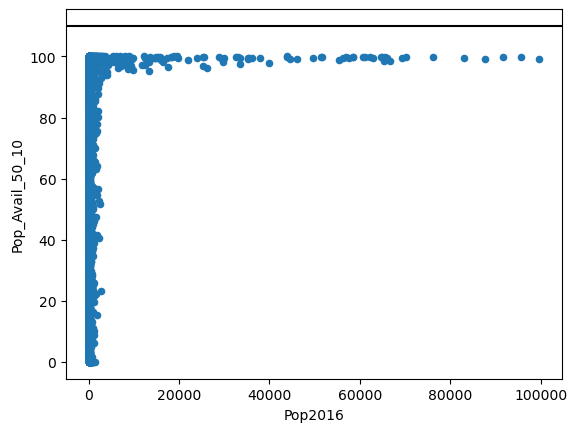

In [25]:
o.plot.scatter(x='Pop2016',y='Pop_Avail_50_10')
ax = plt.gca()
ax.axhline(110,color='k',zorder=100)

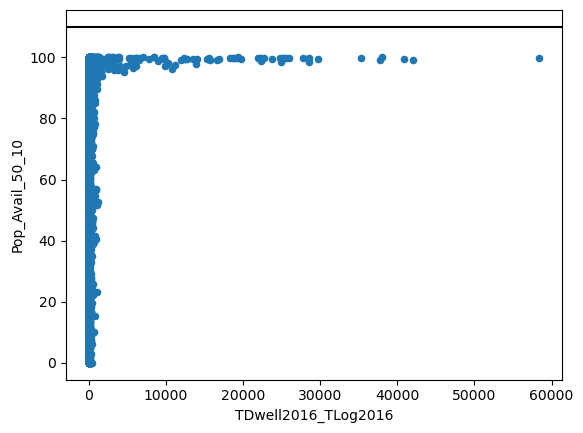

In [38]:
#TDwell2016_TLog2016: total number of dwellings or housing units in a specific location in the year 2016.
o.plot.scatter(x='TDwell2016_TLog2016',y='Pop_Avail_50_10')
ax = plt.gca()
ax.axhline(110,color='k',zorder=100)

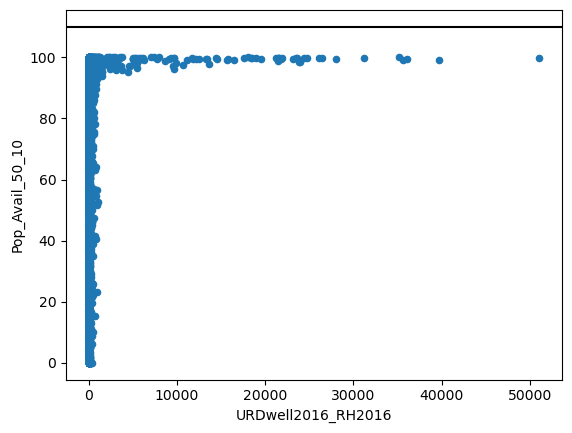

In [47]:
#URDwell2016_RH2016  the proportion of urban dwellings or housing units with a specific type of heating system in a specific location 
o.plot.scatter(x='URDwell2016_RH2016',y='Pop_Avail_50_10')
ax = plt.gca()
ax.axhline(110,color='k',zorder=100)

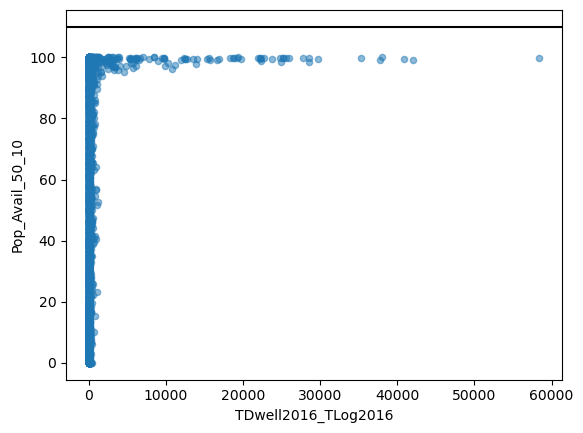

In [46]:
o.plot.scatter(x='TDwell2016_TLog2016',y='Pop_Avail_50_10',alpha=0.5)
ax = plt.gca()
ax.axhline(110,color='k',zorder=100)

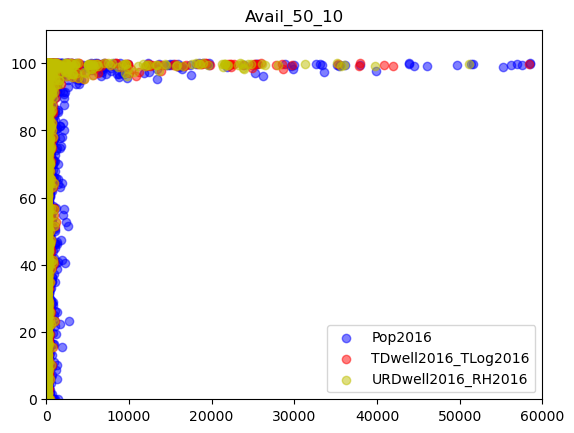

In [48]:


plt.scatter(o['Pop2016'],o['Pop_Avail_50_10'],c='b',alpha=0.5,label="Pop2016")
plt.scatter(o['TDwell2016_TLog2016'],o['Pop_Avail_50_10'],c='r',alpha=0.5,label="TDwell2016_TLog2016")
plt.scatter(o['URDwell2016_RH2016'],o['Pop_Avail_50_10'],c='y',alpha=0.5,label="URDwell2016_RH2016")

plt.xlim([0,60000])
plt.ylim([0,110])

plt.legend(loc="best")

plt.title("Avail_50_10");

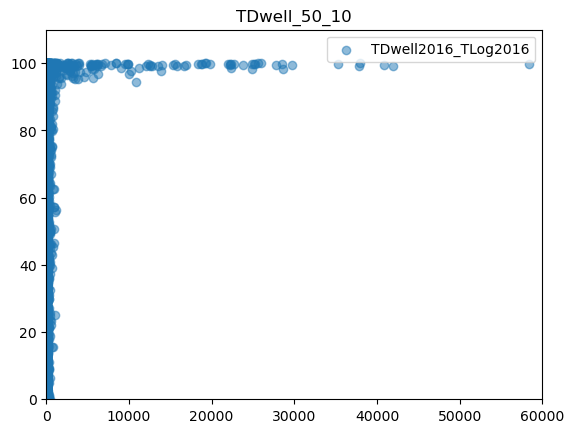

In [53]:
# plt.scatter(o['Pop2016'],o['Pop_Avail_50_10'],c='b',alpha=0.5,label="Pop2016")
plt.scatter(o['TDwell2016_TLog2016'],o['TDwell_Avail_50_10'],alpha=0.5,label="TDwell2016_TLog2016")
# plt.scatter(o['URDwell2016_RH2016'],o['URDwell_Avail_50_10'],c='y',alpha=0.5,label="URDwell2016_RH2016")

plt.xlim([0,60000])
plt.ylim([0,110])

plt.legend(loc="best")

plt.title("TDwell_50_10");

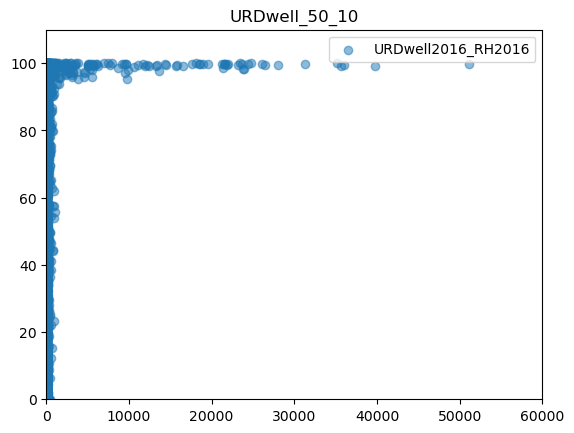

In [54]:
# plt.scatter(o['Pop2016'],o['Pop_Avail_50_10'],c='b',alpha=0.5,label="Pop2016")
# plt.scatter(o['TDwell2016_TLog2016'],o['TDwell_Avail_50_10'],c='b',alpha=0.5,label="TDwell2016_TLog2016")
plt.scatter(o['URDwell2016_RH2016'],o['URDwell_Avail_50_10'],alpha=0.5,label="URDwell2016_RH2016")

plt.xlim([0,60000])
plt.ylim([0,110])

plt.legend(loc="best")

plt.title("URDwell_50_10");

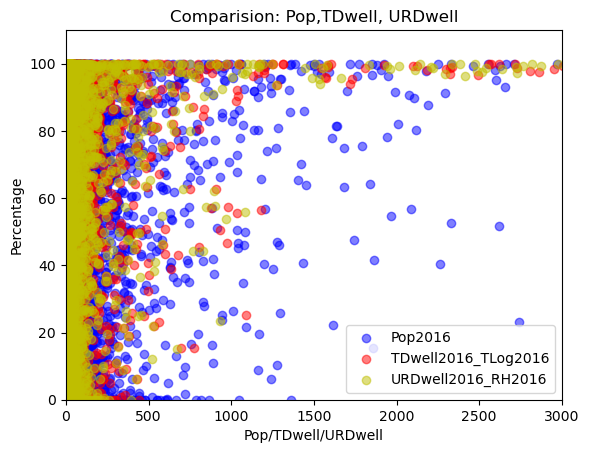

In [63]:
plt.scatter(o['Pop2016'],o['Pop_Avail_50_10'],c='b',alpha=0.5,label="Pop2016")
plt.scatter(o['TDwell2016_TLog2016'],o['TDwell_Avail_50_10'],c='r',alpha=0.5,label="TDwell2016_TLog2016")
plt.scatter(o['URDwell2016_RH2016'],o['URDwell_Avail_50_10'],c='y',alpha=0.5,label="URDwell2016_RH2016")

# plt.xlim([0,60000])
plt.xlim([0,3000])

plt.ylim([0,110])

plt.legend(loc="best")
plt.ylabel("Percentage")
plt.xlabel("Pop/TDwell/URDwell")
plt.title("Comparision: Pop,TDwell, URDwell");

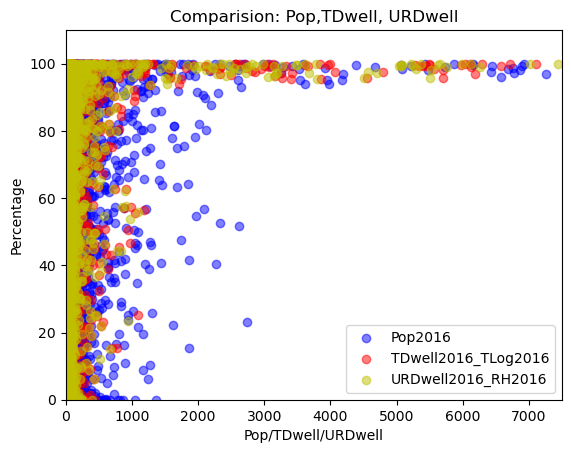

In [64]:
plt.scatter(o['Pop2016'],o['Pop_Avail_50_10'],c='b',alpha=0.5,label="Pop2016")
plt.scatter(o['TDwell2016_TLog2016'],o['TDwell_Avail_50_10'],c='r',alpha=0.5,label="TDwell2016_TLog2016")
plt.scatter(o['URDwell2016_RH2016'],o['URDwell_Avail_50_10'],c='y',alpha=0.5,label="URDwell2016_RH2016")

# plt.xlim([0,60000])
plt.xlim([0,7500])

plt.ylim([0,110])

plt.legend(loc="best")

plt.ylabel("Percentage")
plt.xlabel("Pop/TDwell/URDwell")
plt.title("Comparision: Pop,TDwell, URDwell");

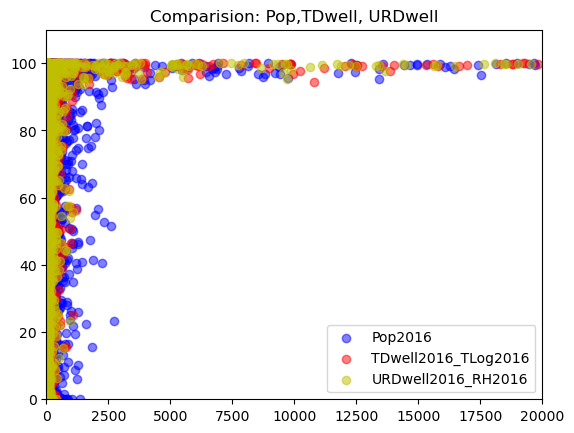

In [58]:

plt.scatter(o['Pop2016'],o['Pop_Avail_50_10'],c='b',alpha=0.5,label="Pop2016")
plt.scatter(o['TDwell2016_TLog2016'],o['TDwell_Avail_50_10'],c='r',alpha=0.5,label="TDwell2016_TLog2016")
plt.scatter(o['URDwell2016_RH2016'],o['URDwell_Avail_50_10'],c='y',alpha=0.5,label="URDwell2016_RH2016")

# plt.xlim([0,60000])
plt.xlim([0,20000])

plt.ylim([0,110])

plt.legend(loc="best")

plt.title("Comparision: Pop,TDwell, URDwell");

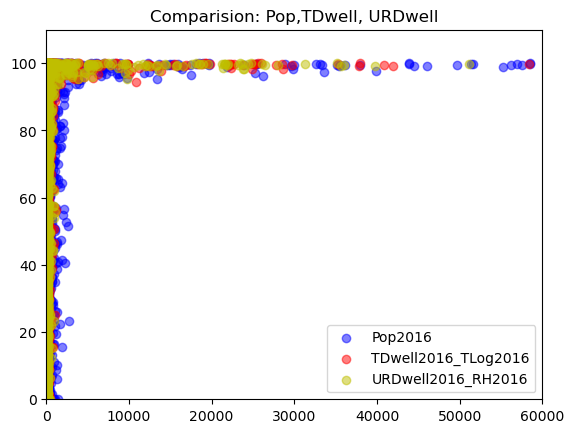

In [59]:
plt.scatter(o['Pop2016'],o['Pop_Avail_50_10'],c='b',alpha=0.5,label="Pop2016")
plt.scatter(o['TDwell2016_TLog2016'],o['TDwell_Avail_50_10'],c='r',alpha=0.5,label="TDwell2016_TLog2016")
plt.scatter(o['URDwell2016_RH2016'],o['URDwell_Avail_50_10'],c='y',alpha=0.5,label="URDwell2016_RH2016")

# plt.xlim([0,60000])
plt.xlim([0,60000])

plt.ylim([0,110])

plt.legend(loc="best")

plt.title("Comparision: Pop,TDwell, URDwell");